# Setup

In [1]:
import crispr as cr 
from crispr.crispr_class import Crispr
import pertpy
import muon
import os
import pandas as pd
import numpy as np
from config import (files_data, col_cell_type_data, col_gene_symbols_data, 
                    assays_data, layer_perturbation_data,
                    col_perturbation_data, key_control_data, 
                    col_split_by_data, layer_perturbation_data,
                    label_perturbation_type_data, col_target_genes_data,
                    key_treatment_data, col_guide_rna_data, col_batch_data,
                    col_sample_id_data, load_example_data)

# Options
skip_preprocessing_clustering = False  # to skip these steps
print(dir(cr.ax))
# file = "CRISPRi_scr"
# file = "CRISPRi_ess"
file = "ECCITE"
# file = "augur_ex"
# file = "screen"
# file = "coda"
# file = "perturb-seq"
write_public = True  # if need to download public data, write to examples/data?

#  Set Arguments
col_cell_type = col_cell_type_data[file]
col_sample_id = col_sample_id_data[file]
col_perturbation = col_perturbation_data[file]
col_target_genes = col_target_genes_data[file]
key_control, label_perturbation_type, layer = [
    x[file] for x in [key_control_data, label_perturbation_type_data,
                      layer_perturbation_data]
]
col_gene_symbols = col_gene_symbols_data[file]
if file in assays_data:
    if isinstance(assays_data[file], str) or assays_data[file] is None:
        assays_data[file] = [assays_data[file], None]
    assay, assay_protein = assays_data[file]
else:
    assay, assay_protein = None
key_treatment = key_treatment_data[file]
col_split_by = col_split_by_data[file]
col_guide_rna = col_guide_rna_data[file]
layer_perturbation = layer_perturbation_data[file]
file_path = files_data[file]
col_batch = col_batch_data[file]
kwargs_init = dict(assay=assay, assay_protein=assay_protein,
                   col_gene_symbols=col_gene_symbols, 
                   col_cell_type=col_cell_type, col_sample_id=col_sample_id, 
                   col_perturbation=col_perturbation, col_guide_rna=col_guide_rna,
                   col_target_genes=col_target_genes, col_batch=col_batch,
                   layer_perturbation=layer_perturbation,
                   label_perturbation_type=label_perturbation_type,
                   key_control=key_control, key_treatment=key_treatment)
print(files_data)

['__builtins__', '__cached__', '__doc__', '__file__', '__loader__', '__name__', '__package__', '__path__', '__spec__', 'analyze_composition', 'cluster', 'clustering', 'compute_distance', 'perform_augur', 'perform_differential_prioritization', 'perform_mixscape', 'perturbations']
{'CRISPRi_scr': '/home/asline01/projects/crispr/examples/data/crispr-screening/filtered_feature_bc_matrix_HH06.h5', 'CRISPRi_wgs': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_gwps.h5ad', 'CRISPRi_ess': '/home/asline01/projects/crispr/examples/data/replogle_2022_k562_esss.h5ad', 'pool': '/home/asline01/projects/crispr/examples/data/norman_2019_raw.h5ad', 'bulk': '/home/asline01/projects/crispr/examples/data/burczynski_crohn.h5ad', 'screen': '/home/asline01/projects/crispr/examples/data/dixit_2016_raw.h5ad', 'perturb-seq': '/home/asline01/projects/crispr/examples/data/adamson_2016_upr_perturb_seq.h5ad', 'ECCITE': '/home/asline01/projects/crispr/examples/data/papalexi_2021.h5ad', 'coda': '/hom

# Setup Object

## Instantiate

In [2]:
# Initialize Object
print(f"Initialization keyword arguments (from config):\n{kwargs_init}")
if skip_preprocessing_clustering:
    file_path_new = os.path.splitext(file_path)[0] + "_processed" + ".h5ad"
    if os.path.exists(file_path_new):
        file_path = os.path.splitext(file_path)[0] + "_processed" + ".h5ad"
    else:
        print(f"Can't skip. {file_path_new} does not exist.")
        skip_preprocessing_clustering
if file == "ECCITE":
    ann = Crispr(pertpy.data.papalexi_2021(), **kwargs_init)
else:
    ann = Crispr(file_path, **kwargs_init)
    
# Make New Variable
if file == "CRISPRi_ess":
    ann.adata.obs[ann._columns["col_target_genes"]] = ann.adata.obs[
        col_target_genes].astype(str).str.strip(" ").replace(
            "", ann._keys["key_control"]).replace(
                np.nan,  ann._keys["key_control"])
    ann.adata.obs[ann._columns["col_perturbation"]] = ann.adata.obs[
        ann._columns["col_target_genes"]]
    ann.adata = ann.adata[ann.adata.obs["guide_ids"].isin(
        ["CDKN1A", "CDKN1A,CDKN1B", "CEBPA", "CEBPB", 
         "CEBPA,CEBPB"])]  # subset for speed

Initialization keyword arguments (from config):
{'assay': 'rna', 'assay_protein': 'adt', 'col_gene_symbols': None, 'col_cell_type': 'leiden', 'col_sample_id': 'orig.ident', 'col_perturbation': 'perturbation', 'col_guide_rna': 'guide_ID', 'col_target_genes': 'gene_target', 'col_batch': nan, 'layer_perturbation': 'X_pert', 'label_perturbation_type': 'KO', 'key_control': 'NT', 'key_treatment': 'Perturbed'}

<<< LOADING OBJECT>>>


 MuData object with n_obs × n_vars = 20729 × 18776
  4 modalities
    rna:	20729 x 18649
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    adt:	20729 x 4
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classif

## Preprocess and Cluster

See `ann.figures[run_label]["clustering"]` (object attribute) or figs_qc[] (method output) for figures.

You must set use_highly_variable to False if you don't want to filter by HVGs
and if you did not set kws_hvg to None or False in `.preprocess()`


In that scenario, the 'highly_variable' column in  will be created in `.obsm` 
during `.preprocess()` and then used by defualt in `.cluster`.

MuData object with n_obs × n_vars = 20729 × 18776
  4 modalities
    rna:	20729 x 18649
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    adt:	20729 x 4
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'
    hto:	20729 x 12
      obs:	'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'nCount_HTO', 'nFeature_HTO', 'nCount_GDO', 'nCount_ADT', 'nFeature_ADT', 'percent.mito', 'MULTI_ID', 'HTO_classification', 'guide_ID', 'gene_target', 'NT', 'perturbation', 'replicate', 'S.Score', 'G2M.Score', 'Phase'
      var:	'name'


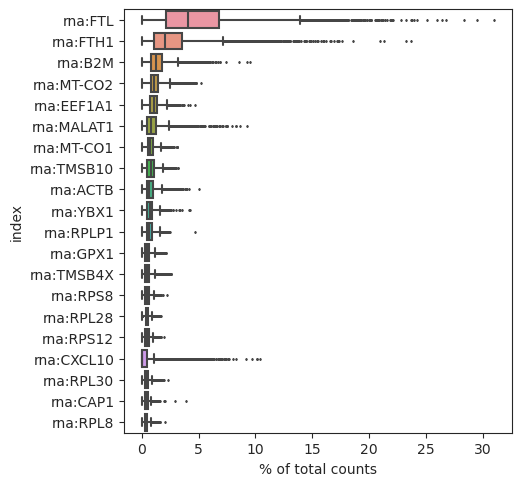


<<< FILTERING >>>

<<< DETECTING MITOCHONDRIAL GENES >>>

<<< PERFORMING QUALITY CONTROL >>>


In [3]:
if not skip_preprocessing_clustering:
    # Filtering, Normalization, Scaling, QC
    cnfnd = None
    # cnfnd = ['total_counts', 'pct_counts_mt']
    # cnfnd=["total_counts", "pct_counts_mt", col_batch]
    process_kws = dict(kws_hvg=dict(min_mean=0.0125, max_mean=3, min_disp=0.5),
                       target_sum=1e4, max_genes_by_counts=2500, max_pct_mt=5, 
                       min_genes=200, min_cells=3, scale=10, regress_out=cnfnd)
    figs_qc = ann.preprocess(**process_kws)  # preprocessing 
    kws_pca = dict(n_comps=None, use_highly_variable=True)

    # Clustering
    ann.cluster(paga=False, method_cluster="leiden",
                kws_pca=kws_pca, kws_neighbors=None, 
                kws_umap=None, kws_cluster=None)

# Analyses

## Cell Type Perturbation Response

Which cell types are most affected by perturbations? Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of condition labels (e.g., treated versus untreated, )

<u> __Features__ </u>  

- Quantify and visualize degree of perturbation response by cell type

<u> __Input__ </u>  

<u> __Output__ </u>  

mean_augur_score

<u> __Notes__ </u>  

- By default, this method will use the 
- Sub-sample sizes equal across condiitons; does not account for perturbation-induced compositional shifts (cell type abundance)
- Scores are for cell types (aggregated across cells, not individual cells)
- Two modes
    - If select_variance_feature=True, run the original Augur implementation, which removes genes that don't vary much across cell type.
    - If False, use features selected by `scanpy.pp.highly_variable_genes()`, which is faster and sensitively recovers effects; however, the feature selection may yield inflated Augur scores because this reduced feature set is used in training, resulting in it taking advantage of the pre-existing power of this feature selection to separate cell types.

In [1]:
conds = ann.adata.obs[ann._columns["col_perturbation"]].unique()  # choose a perturbation
augur_data, augur_results, figs_augur = ann.run_augur(
    key_treatment=conds[conds != ann._keys["key_control"]][0],
    classifier="random_forest_classifier", augur_mode="augur", 
    select_variance_features=False, subsample_size=10)

NameError: name 'ann' is not defined

# Q

Which cell types are most affected by perturbations? Quantify perturbation responses by cell type with Augur, which uses supervised machine learning classification of condition labels (e.g., treated versus untreated) and looking at how easy it is to tell perturbed versus non-perturbed (more separable = higher effect).

<u> __Features__ </u>  

- Remove confounds (e.g., cell cycle, batch effects)
- Identify cells that were/were not (i.e., "escapees") affected by the perturbation
- Quantify and visualize degree of perturbation response by cell type

<u> __Input__ </u>  

<u> __Output__ </u>  
- Mixscape figures

<u> __Notes__ </u>  


In [5]:
figs_mixscape = ann.run_mixscape()

Un-used Keyword Arguments: {'col_gene_symbols': None, 'col_cell_type': 'leiden', 'col_sample_id': 'orig.ident', 'col_batch': nan}


## Distance Metrics

See `ann.figures[run_label]["distances"]` and  `ann.results[run_label]["distances"]`
for results.

In [ ]:
# adata = load_example_data(file, col_gene_symbols, 
#                           write_public=write_public)  # (down)load h5ad file
# adata = cr.pp.process_data(adata, assay=assay, assay_protein=assay_protein,
#                            **process_kws)  # process
# figs_cluster = cr.ax.clustering.cluster(adata, assay=assay, plot=True,
#                                         method_cluster="leiden")
# figs_distance = cr.ax.compute_distance(adata, col_perturbation, col_cell_type=col_cell_type, 
#                                        distance_type="edistance", method="X_pca",
#                                        kws_plot=None, highlight_real_range=False, plot=True)

In [ ]:
fig_distance = ann.compute_distance(distance_type="edistance", method="X_pca")